# Link google drive

In [1]:
# set working pathway to your own google drive doc
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load R magic
%load_ext rpy2.ipython

# Download example dataset(s)

In [ ]:
#main dir
import os
try:
  os.mkdir("/content/drive/My Drive/PP_Bioinformatics/")
except FileExistsError:
  print("directory already exist. OK to continue")

In [ ]:
#project 1
import os
try:
  os.mkdir("/content/drive/My Drive/PP_Bioinformatics/1.SC/")
except FileExistsError:
  print("directory already exist. OK to continue")
try:
  os.mkdir("/content/drive/My Drive/PP_Bioinformatics/1.SC/datasets/")
except FileExistsError:
  print("directory already exist. OK to continue")
try:
  os.mkdir("/content/drive/My Drive/PP_Bioinformatics/1.SC/results/")
except FileExistsError:
  print("directory already exist. OK to continue")

In [ ]:
#download dataset GSE232240
import os
os.chdir("/content/drive/My Drive/PP_Bioinformatics/1.SC/datasets/")
if os.path.isfile("/content/drive/My Drive/PP_Bioinformatics/1.SC/datasets/GSE232240_count.txt"):
  print("Already have GSE232240_count.txt")
else:
  !wget -O GSE232240_count.txt.gz ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7324nnn/GSM7324294/suppl/GSM7324294_Count_data_IMCISION.txt.gz
  !gzip -d GSE232240_count.txt.gz
if os.path.isfile("/content/drive/My Drive/PP_Bioinformatics/1.SC/datasets/GSE232240_metadata.txt"):
  print("Already have GSE232240_metadata.txt")
else:
  !wget -O GSE232240_metadata.txt.gz ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7324nnn/GSM7324295/suppl/GSM7324295_Meta_data_IMCISION.txt.gz
  !gzip -d GSE232240_metadata.txt.gz

In [ ]:
!head GSE232240_count.txt

# Install packages

In [ ]:
#10min to 30min
%%R
install.packages("Seurat")

In [ ]:
#1min
%%R
install.packages("harmony")

In [ ]:
#20min
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("SingleR")

In [ ]:
#5min
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("celldex")

In [ ]:
#5min
%%R
install.packages("ggpubr")

In [ ]:
%%R
install.packages("pheatmap")

In [12]:
%%R
library(Seurat)
library(dplyr)
library(harmony)
library(SingleR)
library(pheatmap)
library(ggpubr)


In [14]:
%%R
tar("library.tar.gz", "/usr/local/lib/R/site-library")

In [15]:
%cp library.tar.gz /content/drive/MyDrive/R_packages/

# Library the packages

In [3]:
%cp drive/MyDrive/R_packages/library.tar.gz .
!tar xf library.tar.gz

tar: Removing leading `/' from member names


In [1]:
##change to R core
.libPaths('usr/local/lib/R/site-library/')

In [3]:
library(Seurat)
library(dplyr)
library(harmony)
library(SingleR)
library(pheatmap)
library(ggpubr)

# Seurat V3 object(s) creating

In [5]:
#read the original count
new_counts=read.table(file="/content/drive/MyDrive/PP_Bioinformatics/1.SC/datasets/GSE232240_count.txt")

In [6]:
#Seurat V3 object, v5 will be mentioned in subsequent files
assay.v3=CreateAssayObject(counts=new_counts)
GSE232240_scRNA=CreateSeuratObject(assay.v3)

In [7]:
#read the metadata
GSE232240_metadata=read.table("/content/drive/MyDrive/PP_Bioinformatics/1.SC/datasets/GSE232240_metadata.txt",sep='\t',header=T)

In [8]:
#get information from metadata
GSE232240_scRNA[["patient"]]=GSE232240_metadata$patient
GSE232240_scRNA[["response"]]=GSE232240_metadata$response
GSE232240_scRNA[["timepoint"]]=GSE232240_metadata$timepoint
GSE232240_scRNA[["mc_group"]]=GSE232240_metadata$mc_group
GSE232240_scRNA[["cell_type"]]=GSE232240_metadata$cell_type

In [ ]:
head(GSE232240_scRNA@meta.data)

In [ ]:
#make a backup of the dataset
save(GSE232240_scRNA,file="/content/drive/MyDrive/PP_Bioinformatics/1.SC/results/GSE232240_scRNA.RData")

# Quality control

In [4]:
#calculate the percentage of mt, rb and HB RNA
if(!"GSE232240_scRNA" %in% ls()) load("/content/drive/MyDrive/PP_Bioinformatics/1.SC/results/GSE232240_scRNA.RData")
GSE232240_scRNA[["percent.mt"]]=PercentageFeatureSet(GSE232240_scRNA,pattern="^MT-")
GSE232240_scRNA[["percent.rb"]]=PercentageFeatureSet(GSE232240_scRNA,pattern="^RP[SL]")
HB.genes=c("HBA1","HBA2","HBB","HBD","HBE1","HBG1","HBG2","HBM","HBQ1","HBZ")
HB.genes=CaseMatch(HB.genes,rownames(GSE232240_scRNA))
GSE232240_scRNA[["percent.HB"]]=PercentageFeatureSet(GSE232240_scRNA,features=HB.genes)

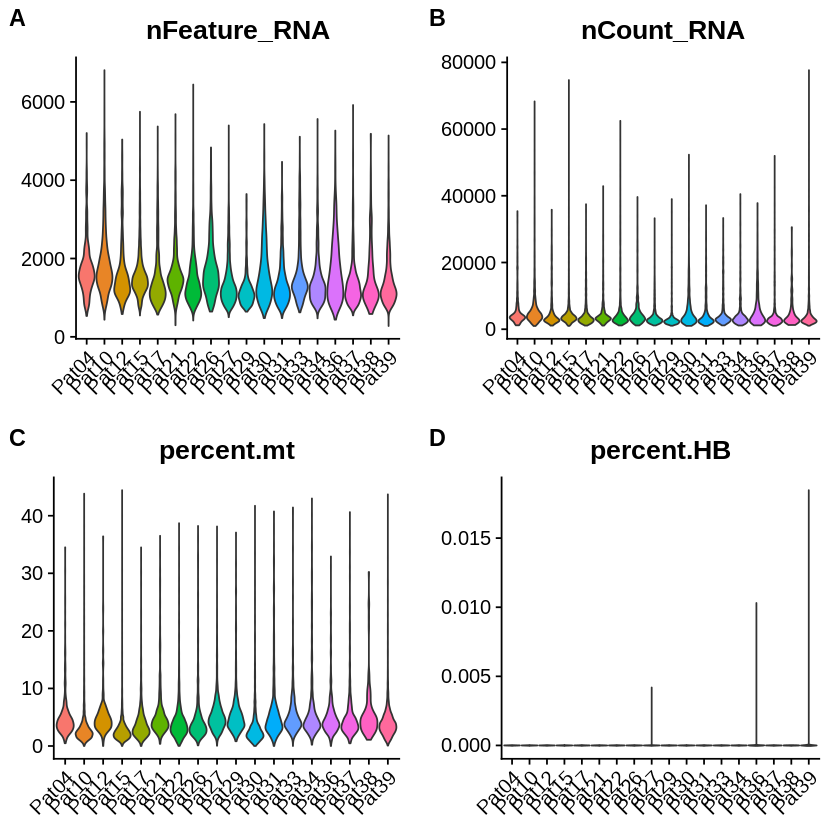

In [5]:
#a glance at reads' quality
p1=VlnPlot(GSE232240_scRNA,features=c("nFeature_RNA"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
p2=VlnPlot(GSE232240_scRNA,features=c("nCount_RNA"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
p3=VlnPlot(GSE232240_scRNA,features=c("percent.mt"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
p4=VlnPlot(GSE232240_scRNA,features=c("percent.HB"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
ggarrange(p1,p2,p3,p4,labels=c("A","B","C","D"),ncol=2,nrow=2)

In [6]:
#filter out low quality reads
GSE232240_scRNA=subset(GSE232240_scRNA,subset=percent.HB<1&nCount_RNA<15000&percent.mt<10)

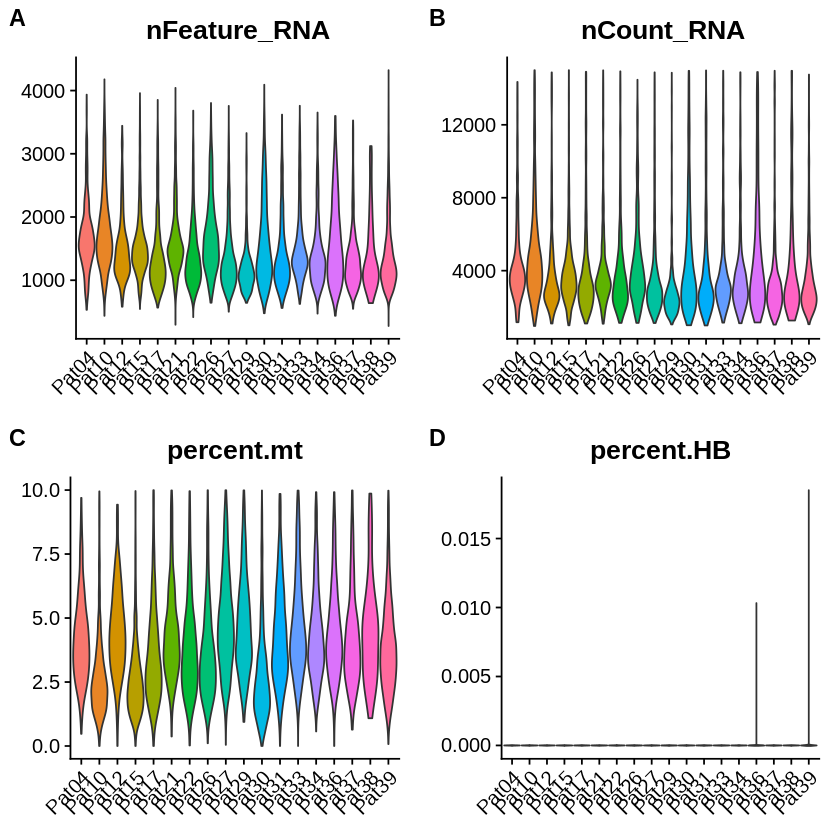

In [13]:
#a glance at reads' quality after filtering
p5=VlnPlot(GSE232240_scRNA,features=c("nFeature_RNA"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
p6=VlnPlot(GSE232240_scRNA,features=c("nCount_RNA"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
p7=VlnPlot(GSE232240_scRNA,features=c("percent.mt"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
p8=VlnPlot(GSE232240_scRNA,features=c("percent.HB"),raster=FALSE,
        group.by="patient",pt.size=0)+theme(axis.title.x=element_blank())+NoLegend()
ggarrange(p5,p6,p7,p8,labels=c("A","B","C","D"),ncol=2,nrow=2)

# PCA

Centering and scaling data matrix



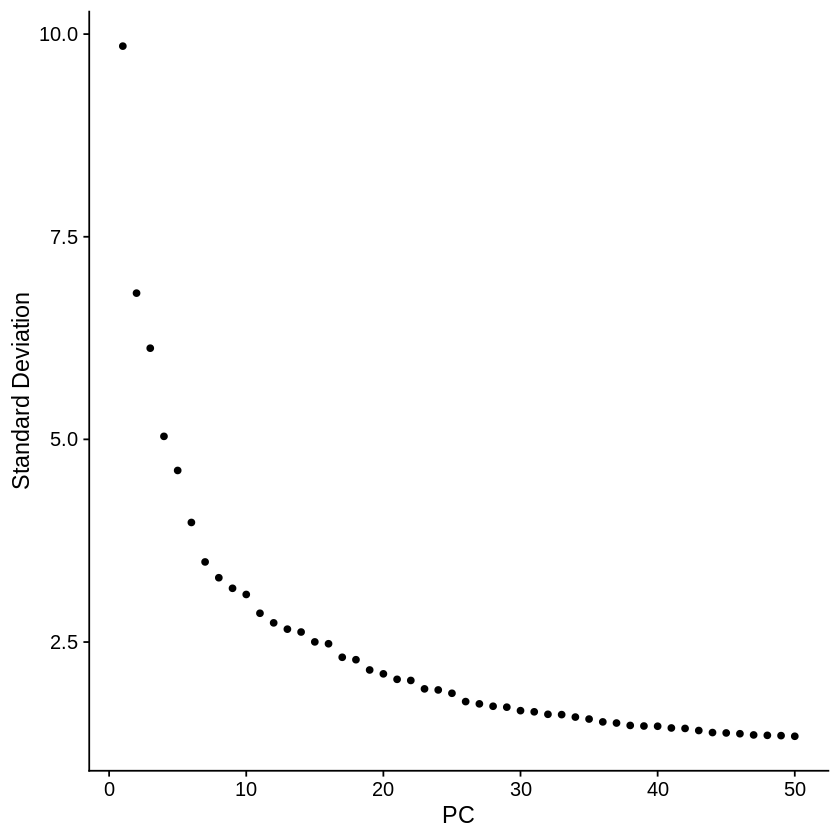

In [7]:
GSE232240_scRNA=NormalizeData(GSE232240_scRNA) %>% FindVariableFeatures(nfeatures=2000) %>% ScaleData()
GSE232240_scRNA=RunPCA(GSE232240_scRNA,verbose=F)
ElbowPlot(GSE232240_scRNA,ndims=50)

# Integration by harmony

Warning message:
“Warning: The parameter max.iter.harmony is replaced with parameter max_iter. It will be ignored for this function call and please use parameter max_iter in future function calls.
This warning is displayed once per session.”
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



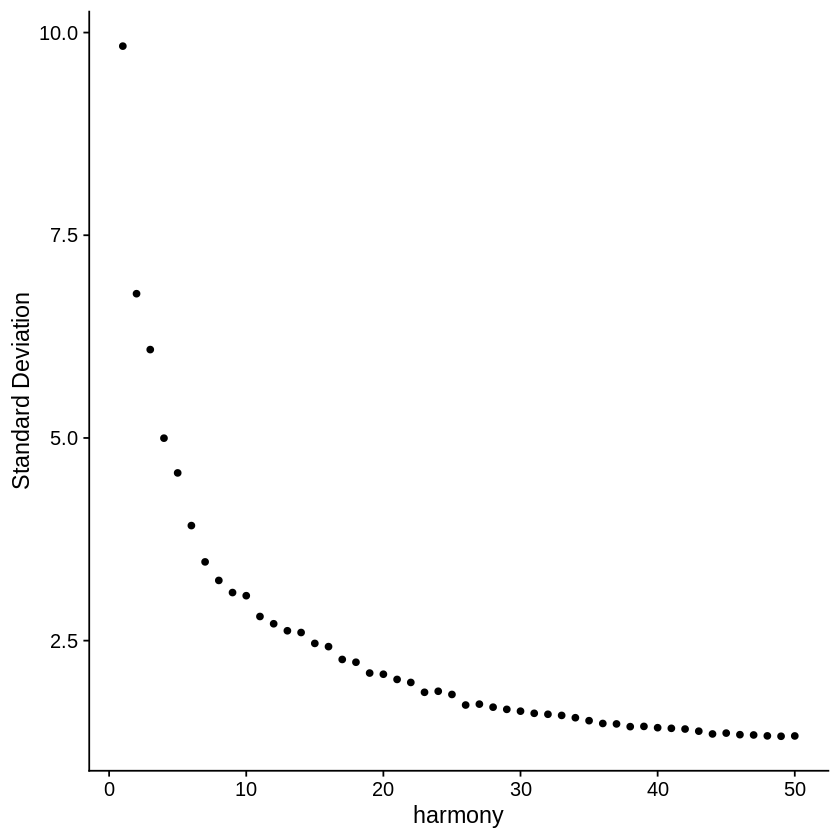

In [8]:
#it's not necessary just for showing how to integrate. More detailed information could be seen in the following files
GSE232240_scRNA=RunHarmony(GSE232240_scRNA,group.by.vars="timepoint",max.iter.harmony=20)
ElbowPlot(GSE232240_scRNA,ndims=50,reduction='harmony')

# Deduction and visualization

In [ ]:
#tsne and umap
GSE232240_scRNA=RunTSNE(GSE232240_scRNA,reduction='harmony',dims=1:40) %>% RunUMAP(reduction='harmony',dims=1:40)
GSE232240_scRNA=FindNeighbors(GSE232240_scRNA,dims=1:40,reduction='harmony') %>% FindClusters(resolution=1)

In [ ]:
DimPlot(GSE232240_scRNA,label=T)

In [ ]:
p9=DimPlot(GSE232240_scRNA,group.by="timepoint")
p10=DimPlot(GSE232240_scRNA,group.by="patient")
p11=DimPlot(GSE232240_scRNA,group.by="timepoint",reduction='tsne')
p12=DimPlot(GSE232240_scRNA,group.by="patient",reduction='tsne')
ggarrange(p9,p10,p11,p12,labels=c("A","B","C","D"),ncol=2,nrow=2)

In [ ]:
#make a backup of dataset
save(GSE232240_scRNA,file="/content/drive/MyDrive/PP_Bioinformatics/1.SC/results/GSE232240_scRNA_harmony.RData")

# Cell anotation by singleR

In [17]:
#load reference dataset
if(!"GSE232240_scRNA" %in% ls()) load("/content/drive/MyDrive/PP_Bioinformatics/1.SC/results/GSE232240_scRNA_harmony.RData")
ref1=celldex::MonacoImmuneData()

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache



In [18]:
#get cell annotation
pred.scRNA=SingleR(test=GSE232240_scRNA@assays$RNA@data,ref=ref1,labels=ref1$label.fine,clusters=GSE232240_scRNA@active.ident)
new.cluster.ids=pred.scRNA$pruned.labels
names(new.cluster.ids)=levels(GSE232240_scRNA)

In [19]:
#move the cell annotation to metadata, it is not necessary but for convenience
GSE232240_scRNA=RenameIdents(GSE232240_scRNA,new.cluster.ids)
GSE232240_scRNA[['cell_anotation']]=GSE232240_scRNA@active.ident

In [1]:
TSNEPlot(object=GSE232240_scRNA,pt.size=0.5,label=F)

ERROR: ignored

In [ ]:
DimPlot(GSE232240_scRNA,group.by="response",split.by='cell_anotation',ncol=4,reduction='tsne')

In [ ]:
#make a backup of dataset
save(GSE232240_scRNA,file="/content/drive/MyDrive/PP_Bioinformatics/1.SC/results/GSE232240_scRNA_singleR.RData")

# Differential cell proportion analysis

In [ ]:
if(!"GSE232240_scRNA" %in% ls()) load("/content/drive/MyDrive/PP_Bioinformatics/1.SC/results/GSE232240_scRNA_singleR.RData")

In [ ]:
x=names(table(GSE232240_scRNA@meta.data$patient))

In [ ]:
#get the matrix needed for heatmap
tep=table(GSE232240_scRNA@meta.data$cell_anotation[GSE232240_scRNA@meta.data$patient=="Pat04"])
datHM=names(tep)
datHM=data.frame(datHM,as.numeric(tep)/sum(as.numeric(tep)))
group=c();group[1]=GSE232240_scRNA@meta.data$response[GSE232240_scRNA@meta.data$patient==x[1]][1]
for (i in x[2:length(x)]) {
  tep=table(GSE232240_scRNA@meta.data$cell_anotation[GSE232240_scRNA@meta.data$patient==i])
  group[i]=GSE232240_scRNA@meta.data$response[GSE232240_scRNA@meta.data$patient==i][1]
  c=as.numeric(tep)
  d=c/sum(c)
  datHM=data.frame(datHM,d)
}
datHM=datHM[-1]
rownames(datHM)=names(tep);colnames(datHM)=x
head(datHM)

In [ ]:
#get annotation of group
anno_col=data.frame(group);rownames(anno_col)=x;names(anno_col)='Group'
pheatmap(datHM,show_colnames=T,annotation_col=anno_col)

In [ ]:
#Wilcoxon test
infer=anno_col[names(datHM),]
a=c();b=c()
for (i in 1:length(datHM$Pat04)) {
  b[i]=wilcox.test(as.numeric(datHM[i,infer=="NR"]),
                   as.numeric(datHM[i,infer=="RE"]),exact=F)$p.value
  a[i]=rownames(datHM)[i]
}
data.frame(a,b)